# 03. rajpurohitpooja/Salary_Prediction_Portfolio

## Predictions with ML Regression Models (T1) - train_features.csv & train_salaries.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, Lasso, Ridge, QuantileRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, get_scorer_names
df = pd.read_csv('03_train_features.csv')
df_salary = pd.read_csv('03_train_salaries.csv')

In [2]:
# Merge these two datasets with 'jobId' column; then show all the columns, counts and their data types
df = df.merge(df_salary, on='jobId')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [3]:
# First 5 rows of the dataset
df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [4]:
# Last 5 rows of the dataset
df.tail()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
999999,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


## Prepare Train and Test Sets

In [5]:
# Create dummy variables from these columns: jobType, degree, major, industry
dummy_jobtype = pd.get_dummies(df['jobType'], prefix='job')
dummy_degree = pd.get_dummies(df['degree'], prefix='deg')
dummy_major = pd.get_dummies(df['major'], prefix='maj')
dummy_industry = pd.get_dummies(df['industry'], prefix='ind')
df_concat = pd.concat([dummy_jobtype, dummy_degree, dummy_major, dummy_industry,
                       df['yearsExperience'], df['milesFromMetropolis'], df['salary']], axis=1)
df_concat.head(10)

,job_CEO,job_CFO,job_CTO,job_JANITOR,job_JUNIOR,job_MANAGER,job_SENIOR,job_VICE_PRESIDENT,deg_BACHELORS,deg_DOCTORAL,...,ind_AUTO,ind_EDUCATION,ind_FINANCE,ind_HEALTH,ind_OIL,ind_SERVICE,ind_WEB,yearsExperience,milesFromMetropolis,salary
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,10,83,130
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,3,73,101
2,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,10,38,137
3,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,8,17,142
4,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,8,16,163
5,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,2,31,113
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,23,24,178
7,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,9,70,73
8,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,54,31
9,0,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,17,68,104


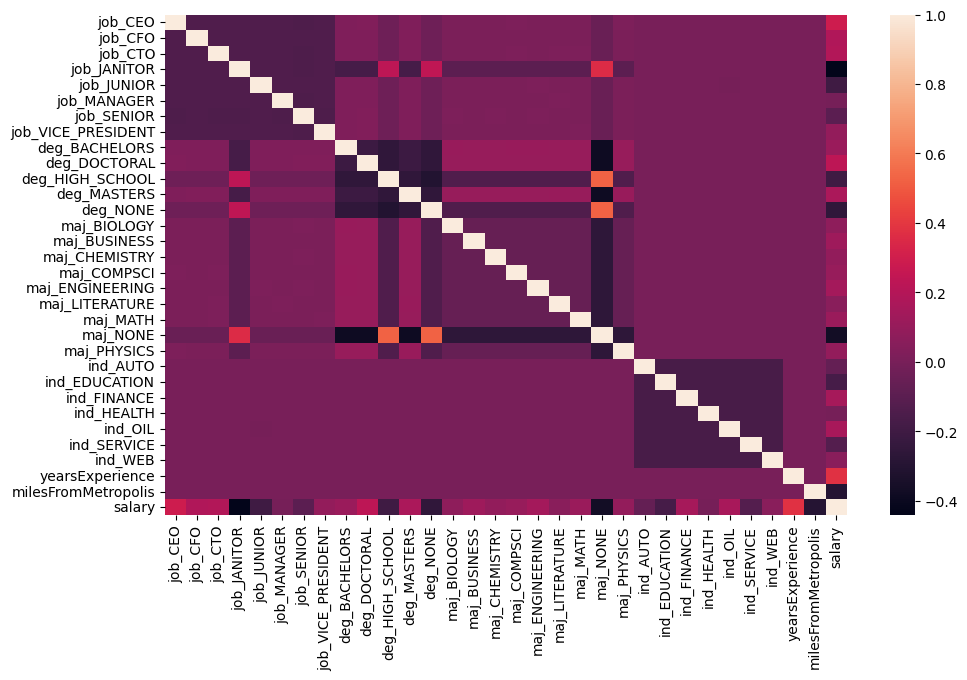

#### CORRELATION VALUES AGAINST SALARIES ####
job_CEO                0.285245
job_CFO                0.188804
job_CTO                0.189600
job_JANITOR           -0.441660
job_JUNIOR            -0.201993
job_MANAGER           -0.006781
job_SENIOR            -0.103642
job_VICE_PRESIDENT     0.090941
deg_BACHELORS          0.111923
deg_DOCTORAL           0.231391
deg_HIGH_SCHOOL       -0.203543
deg_MASTERS            0.171992
deg_NONE              -0.257349
maj_BIOLOGY            0.076341
maj_BUSINESS           0.126124
maj_CHEMISTRY          0.084046
maj_COMPSCI            0.102987
maj_ENGINEERING        0.144176
maj_LITERATURE         0.053920
maj_MATH               0.110401
maj_NONE              -0.371421
maj_PHYSICS            0.092057
ind_AUTO              -0.069913
ind_EDUCATION         -0.175148
ind_FINANCE            0.154847
ind_HEALTH            -0.003439
ind_OIL                0.156959
ind_SERVICE           -0.122361
ind_WEB                0.058949
yearsExperience        0.3

In [6]:
# Show the correlations of all concatenated columns in a heat map
plt.figure(figsize=(11,6.5))
sns.heatmap(df_concat.corr())
plt.show()
print("#### CORRELATION VALUES AGAINST SALARIES ####")
print(df_concat.corr()['salary'])

### Type 1: Use All Columns

In [7]:
# Use 80% of the dataset as train set, and 20% as test set
X = df_concat.drop(columns='salary', axis=1)
Y = df_concat.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21)
print("TRAIN SIZE:", x_train.shape, y_train.shape, "  TEST SIZE:", x_test.shape, y_test.shape)

TRAIN SIZE: (800000, 31) (800000,)   TEST SIZE: (200000, 31) (200000,)


In [8]:
# Create lists to store results of error values of all regression methods
res_mse, res_rmse, res_mae, res_r2, res_cv_train, res_cv_test = [], [], [], [], [], []

# ML Regression Models

## 1 - Linear Regression

In [9]:
linreg = LinearRegression()
linreg.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [10]:
# Fit the training data into the linear reg. model, then make predictions on the test data
s_time = time.time()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 1.760 seconds.


In [11]:
print("COEF:", linreg.coef_)   # Estimated coefficients for the linear reg.
print("RANK:", linreg.rank_)   # Rank of matrix
print("INTERCEPT:", linreg.intercept_)   # Independent term in the linear model

COEF: [-4.33854087e+08 -4.33854097e+08 -4.33854097e+08 -4.33854149e+08
 -4.33854137e+08 -4.33854117e+08 -4.33854127e+08 -4.33854107e+08
 -4.81517924e+10 -4.81517924e+10 -4.81517924e+10 -4.81517924e+10
 -4.81517924e+10  7.53292977e+10  7.53292977e+10  7.53292977e+10
  7.53292977e+10  7.53292977e+10  7.53292977e+10  7.53292977e+10
  7.53292977e+10  7.53292977e+10 -1.68121693e+10 -1.68121693e+10
 -1.68121692e+10 -1.68121693e+10 -1.68121692e+10 -1.68121693e+10
 -1.68121692e+10  2.00997092e+00 -3.99147138e-01]
RANK: 31
INTERCEPT: -9931481842.496492


In [12]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

    93.6768684387207 |       73
  120.95648002624512 |      100
  130.86008834838867 |      101
   121.6175537109375 |      112
  123.17060852050781 |      130
  110.71889305114746 |      108
  114.63080978393555 |      130
   57.87635040283203 |       43
  172.63073921203613 |      174
   104.1162052154541 |       88
   107.2470760345459 |      103
   167.2730369567871 |      162
   88.12861633300781 |       73
  105.22236442565918 |       96
  131.92337608337402 |      121
  151.19064140319824 |      187
  141.27273750305176 |      173
  100.52414321899414 |       89
  106.47793960571289 |      106
  123.68961524963379 |      160


In [13]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
adj_r2 = 1-(1-linreg.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("MSE:", mse)         # Mean squared error
print("RMSE:", rmse)       # Root mean squared error
print("MAE:", mae)         # Mean absolute error
print("R2 SCORE:", r2)     # R2 score
print("ADJUSTED R2 SCORE:", adj_r2)   # Adjusted R2 score
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(linreg, X, Y, cv=5, return_train_score=True)    # 5-fold Cross Validation
# The time in seconds for fitting the estimator on the train set for each cv split
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
# The time in seconds for scoring the estimator on the test set for each cv split
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
# The score array for train scores for each cv split
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
# The score array for test score for each cv split
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 385.2080736421235
RMSE: 19.626718361512285
MAE: 15.854756020212173
R2 SCORE: 0.7441113759288884
ADJUSTED R2 SCORE: 0.7435248426029517

# CROSS VALIDATION #
FITTING TIME: [1.80877876 1.83000135 1.79938984 1.83947659 1.82321358] -> 1.8201720237731933
SCORING TIME: [0.04929733 0.04914761 0.04917169 0.04888582 0.04770803] -> 0.04884209632873535
TRAIN SCORE: [0.74368874 0.74351897 0.74361972 0.74342849 0.7434112 ] -> 0.7435334230969938
TEST SCORE: [0.74287769 0.74357884 0.74311486 0.74394156 0.7440116 ] -> 0.7435049091634813


## 2 - Lasso Regression

In [14]:
lasso = Lasso()
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [15]:
# Fit the training data into the lasso model, then make predictions on the test data
s_time = time.time()
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 1.258 seconds.


In [16]:
print("COEF:", lasso.coef_)   # Parameter vector (w in the cost function function formula)
print("INTERCEPT:", lasso.intercept_)   # Independent term in decision function
# Number of iterations run by the coord. descent solver to reach the specified tolerance
print("ITERATIONS:", lasso.n_iter_)   

COEF: [ 16.8327781    7.03052323   7.05907956 -32.17705516 -16.93503114
  -0.          -6.9665146    0.          -0.           3.33394759
  -0.           0.          -1.78095878  -0.           0.
  -0.           0.           0.          -0.           0.
 -15.23321194   0.          -0.          -9.08939804   8.00297096
   0.           8.17876672  -4.13125712   0.           1.99222401
  -0.39814119]
INTERCEPT: 122.56614266995092
ITERATIONS: 14


In [17]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

  111.34571030153384 |       73
  120.78352232311617 |      100
  122.51261590978811 |      101
  121.41379811355475 |      112
  110.80599055219591 |      130
  115.76362690463284 |      108
    94.5887977831174 |      130
   64.81786738810945 |       43
  163.86167660571033 |      174
  108.60058116944681 |       88
  118.52439626212475 |      103
  171.32461934923248 |      162
   85.08569635016534 |       73
  105.56138559210112 |       96
  119.56206051329174 |      121
  150.86849369742524 |      187
  141.41989967729472 |      173
   103.3693474222228 |       89
  112.57394318586202 |      106
   115.9571871089093 |      160


In [18]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
adj_r2 = 1-(1-lasso.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("MSE:", mse)          
print("RMSE:", rmse)       
print("MAE:", mae)        
print("R2 SCORE:", r2)
print("ADJUSTED R2 SCORE:", adj_r2)
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(lasso, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 498.6304400013666
RMSE: 22.330034482762596
MAE: 17.93502605054126
R2 SCORE: 0.6687663994019415
ADJUSTED R2 SCORE: 0.6684662628111722

# CROSS VALIDATION #
FITTING TIME: [1.38027549 1.3685801  1.36186528 1.36691475 1.48003387] -> 1.391533899307251
SCORING TIME: [0.05742788 0.04880619 0.04985189 0.04512382 0.05045652] -> 0.050333261489868164
TRAIN SCORE: [0.66875471 0.66873016 0.66884083 0.66848894 0.6687    ] -> 0.6687029279864458
TEST SCORE: [0.66886467 0.66801017 0.66750686 0.66887905 0.67017997] -> 0.6686881449710003


## 3 - Ridge Regression

In [19]:
ridge = Ridge()
ridge.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [20]:
# Fit the training data into the ridge model, then make predictions on the test data
s_time = time.time()
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 0.452 seconds.


In [21]:
print("COEF:", ridge.coef_)   # Weight vector(s)
print("INTERCEPT:", ridge.intercept_)   # Independent term in decision function
print("ITERATIONS:", ridge.n_iter_)   # Actual number of iterations for each target. (Only for 'sag' & 'lsqr' solvers)

COEF: [ 2.76632193e+01  1.78501155e+01  1.78423439e+01 -3.46804398e+01
 -2.21478680e+01 -2.19907886e+00 -1.20974966e+01  7.76920455e+00
  1.74379768e-02  1.00566805e+01 -5.69215846e+00  5.01467283e+00
 -9.39663289e+00 -2.42081385e+00  5.17390795e+00 -1.43623366e+00
  1.57496196e+00  8.12204747e+00 -6.09520987e+00  2.63362480e+00
 -7.41581676e+00 -1.36468054e-01 -6.54764351e+00 -1.65225456e+01
  1.45848916e+01 -2.78034663e-01  1.47321087e+01 -1.15589917e+01
  5.59021520e+00  2.00997709e+00 -3.99146169e-01]
INTERCEPT: 116.18827443148254
ITERATIONS: None


In [22]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   93.68856320664834 |       73
  120.96078568714736 |      100
   130.8720473867805 |      101
   121.6162005311343 |      112
   123.1705004753123 |      130
  110.68224869490643 |      108
  114.68455143712723 |      130
  57.872240494225046 |       43
   172.6205050362438 |      174
  104.12914326092923 |       88
  107.25677302671363 |      103
  167.21587919623028 |      162
   88.07780707656579 |       73
   105.2016450282884 |       96
   131.9232237134629 |      121
  151.19510065526487 |      187
  141.30978254758236 |      173
  100.52601112460057 |       89
  106.48710777441612 |      106
  123.63023430258079 |      160


In [23]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
adj_r2 = 1-(1-ridge.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
print("ADJUSTED R2 SCORE:", adj_r2)
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(ridge, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 385.20715649237894
RMSE: 19.626694996671727
MAE: 15.854798005385536
R2 SCORE: 0.744111985179323
ADJUSTED R2 SCORE: 0.743525278331092

# CROSS VALIDATION #
FITTING TIME: [0.58056474 0.57357407 0.58587909 0.55879807 0.56607103] -> 0.5729773998260498
SCORING TIME: [0.05449581 0.05972075 0.06030846 0.05070949 0.05139422] -> 0.05532574653625488
TRAIN SCORE: [0.74369195 0.74351929 0.74363104 0.74342996 0.74341245] -> 0.7435369388356413
TEST SCORE: [0.7428896  0.74357978 0.74313147 0.74394331 0.74400965] -> 0.7435107622183186


## 4 - Polynomial Regression

In [24]:
poly_feat = PolynomialFeatures(degree=2)
poly_feat.get_params()

{'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}

In [25]:
# Fit then transform for both training and test data (the number of columns must increase)
x_poly_train = poly_feat.fit_transform(x_train)
x_poly_test = poly_feat.fit_transform(x_test)
print(x_poly_train.shape, x_poly_test.shape)

(800000, 528) (200000, 528)


### Polynomial Regression with Lasso

In [26]:
lasso = Lasso(max_iter=500)
s_time = time.time()
lasso.fit(x_poly_train, y_train)
y_poly_pred = lasso.predict(x_poly_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 134.969 seconds.


In [27]:
print("COEF:", lasso.coef_)   # Parameter vector (w in the cost function function formula)
print("INTERCEPT:", lasso.intercept_)   # Independent term in decision function
# Number of iterations run by the coord. descent solver to reach the specified tolerance
print("ITERATIONS:", lasso.n_iter_)  

COEF: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.90467842e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  2.52805939e+00 -2.03116905e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  9

In [28]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_poly_pred), mean_squared_error(y_test, y_poly_pred, squared=False), \
    mean_absolute_error(y_test, y_poly_pred), r2_score(y_test, y_poly_pred)
print("MSE:", mse)          
print("RMSE:", rmse)     
print("MAE:", mae)         
print("R2 SCORE:", r2)    
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(lasso, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 478.9705905015875
RMSE: 21.885396740785566
MAE: 17.63658342208891
R2 SCORE: 0.6818261771744536

# CROSS VALIDATION #
FITTING TIME: [1.60807276 1.45224452 1.37939692 1.39006472 1.38940167] -> 1.4438361167907714
SCORING TIME: [0.06898975 0.05359626 0.05552983 0.05543423 0.05148339] -> 0.05700669288635254
TRAIN SCORE: [0.66875471 0.66873016 0.66884083 0.66848894 0.6687    ] -> 0.6687029279864458
TEST SCORE: [0.66886467 0.66801017 0.66750686 0.66887905 0.67017997] -> 0.6686881449710003


### Polynomial Regression with Ridge

In [29]:
ridge = Ridge(max_iter=2000)
s_time = time.time()
ridge.fit(x_poly_train, y_train)
y_poly_pred = ridge.predict(x_poly_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 9.511 seconds.


In [30]:
print("COEF:", ridge.coef_)   # Weight vector(s)
print("INTERCEPT:", ridge.intercept_)   # Independent term in decision function
print("ITERATIONS:", ridge.n_iter_)   # Actual number of iterations for each target. (Only for 'sag' & 'lsqr' solvers)

COEF: [ 0.00000000e+00  1.05934454e+01  6.83591731e+00  6.51387170e+00
 -9.72687342e+00 -9.58549654e+00 -1.60546220e+00 -5.53115156e+00
  2.50574922e+00 -2.98931403e-01  3.74640888e+00 -1.98049967e+00
  1.80141943e+00 -3.26839740e+00 -7.99293817e-01  2.11328129e+00
 -5.13027494e-01  9.16227354e-01  3.29353606e+00 -2.16111923e+00
  1.10898988e+00 -3.98100118e+00  2.24070288e-02 -2.99045180e+00
 -6.97224873e+00  6.05694552e+00 -1.11683349e-01  6.29741444e+00
 -5.04746845e+00  2.76749187e+00  1.89617653e+00 -1.03363295e-01
  1.05934454e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.87458232e+00  2.15428096e+00  2.57685244e+00  2.20165341e+00
  1.78607641e+00  7.43450737e-01  1.45149572e+00  5.98921997e-01
  1.22985477e+00  1.49180282e+00  8.33101108e-01  1.39760968e+00
  1.84329959e+00  1.00390892e+00  1.42093696e+00  4.24339249e-01
  2.27145937e+00  1.43966816e+00  2.62712957e+00  8.96379869e-01
  1.51353221e+00  2

In [31]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_poly_pred), mean_squared_error(y_test, y_poly_pred, squared=False), \
    mean_absolute_error(y_test, y_poly_pred), r2_score(y_test, y_poly_pred)
print("MSE:", mse)        
print("RMSE:", rmse)       
print("MAE:", mae)          
print("R2 SCORE:", r2)      
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(ridge, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 354.743346172411
RMSE: 18.8346315645518
MAE: 15.312695797588338
R2 SCORE: 0.7643486911056431

# CROSS VALIDATION #
FITTING TIME: [0.69457221 0.62305903 0.59656596 0.56163025 0.58894134] -> 0.6129537582397461
SCORING TIME: [0.0428071  0.04200268 0.042207   0.04425716 0.04363894] -> 0.04298257827758789
TRAIN SCORE: [0.74369195 0.74351929 0.74363104 0.74342996 0.74341245] -> 0.7435369388356413
TEST SCORE: [0.7428896  0.74357978 0.74313147 0.74394331 0.74400965] -> 0.7435107622183186


## 5 - Random Forest Regression

In [32]:
rforest = RandomForestRegressor(n_estimators=25, criterion='friedman_mse', max_depth=25, min_samples_split=2, 
                                min_samples_leaf=2, min_weight_fraction_leaf=0.1, max_features=None, max_leaf_nodes=None,
                                bootstrap=True, warm_start=False, ccp_alpha=0.2, max_samples=None, oob_score=True)
# rforest = RandomForestRegressor(n_estimators=25, criterion='friedman_mse', max_depth=20, min_samples_split=4, 
#                                 min_samples_leaf=4, min_weight_fraction_leaf=0.1, max_features=None, max_leaf_nodes=None,
#                                 bootstrap=True, warm_start=False, ccp_alpha=0.2, max_samples=None)
# rforest = RandomForestRegressor(n_estimators=40)
rforest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.2,
 'criterion': 'friedman_mse',
 'max_depth': 25,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.1,
 'n_estimators': 25,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [33]:
# Fit the training data into the random forest, then make predictions on the test data
s_time = time.time()
rforest.fit(x_train, y_train)
y_pred = rforest.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 23.013 seconds.


In [34]:
print("BASE ESTIMATOR:", rforest.base_estimator_)   # Estimator used to grow the ensemble
# print("ESTIMATORS:", rforest.estimators_)   # The collection of fitted sub-estimators
print("FEATURE IMPORTANCES:", rforest.feature_importances_)   # The impurity-based feature importances
# Score of the training dataset obtained using an out-of-bag estimate. Exists only when oob_score = True
print("OOB SCORE:", rforest.oob_score_)
# Prediction computed with out-of-bag estimate on the training set. Exists only when oob_score = True
print("OOB PREDICTION:", rforest.oob_prediction_, "", len(rforest.oob_prediction_))
print("FEATURES:", rforest.n_features_in_)   # Number of features seen during fit
print("OUTPUTS:", rforest.n_outputs_, "\n")   # The number of outputs when fit is performed

BASE ESTIMATOR: DecisionTreeRegressor()
FEATURE IMPORTANCES: [0.         0.         0.         0.48950653 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.12844454 0.         0.         0.
 0.         0.         0.         0.         0.         0.23218083
 0.1498681 ]
OOB SCORE: 0.4024140033116973
OOB PREDICTION: [156.74545778 112.2234738   70.89948563 ... 156.23193188 130.72134889
 125.41975507]  800000
FEATURES: 31
OUTPUTS: 1 



In [35]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(rforest, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 898.4003532194541
RMSE: 29.973327363164973
MAE: 24.06204411044353
R2 SCORE: 0.4032045380650413

# CROSS VALIDATION #
FITTING TIME: [22.52141476 22.32525229 22.43259907 22.58224154 22.78602815] -> 22.529507160186768
SCORING TIME: [0.24090815 0.25494695 0.23323607 0.24677873 0.2393446 ] -> 0.2430428981781006
TRAIN SCORE: [0.40400103 0.40090741 0.40542249 0.40990673 0.41005431] -> 0.4060583951206265
TEST SCORE: [0.40326937 0.40002456 0.40291834 0.40916917 0.4133772 ] -> 0.4057517285674013


## 6 - Gradient Boosting

In [36]:
gradBoost = GradientBoostingRegressor()
gradBoost.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [37]:
# Fit the training data into the Gradient boosting regression model, then make predictions on the test data
s_time = time.time()
gradBoost.fit(x_train, y_train)
y_pred = gradBoost.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 101.026 seconds.


In [38]:
print("INIT:", gradBoost.init_)  # The estimator that provides the initial predictions
print("ESTIMATORS (FIRST 5):\n{}".format(gradBoost.estimators_[:5]))  # The collection of fitted sub-estimators
# The number of estimators as selected by early stopping (if 'n_iter_no_change' is specified).
# Otherwise, it is set to 'n_estimators'
print("# OF ESTIMATORS:", gradBoost.n_estimators_)
print("# OF FEATURES:", gradBoost.n_features_in_)  # Number of features seen during fit
print("MAX FEATURES:", gradBoost.max_features_)  # The inferred value of max_features
print("FEATURE IMPORTANCES:", gradBoost.feature_importances_)  # The impurity-based feature importances
# The i'th score 'train_score[i]' is the loss of the model at iteration i on the in-bag sample.
# If subsample == 1, this is the loss on the training data.
print("TRAIN SCORE:\n{}".format(gradBoost.train_score_))

INIT: DummyRegressor()
ESTIMATORS (FIRST 5):
[[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1AF2D9A5340)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1AF2D9A5340)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1AF2D9A5340)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1AF2D9A5340)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1AF2D9A5340)]]
# OF ESTIMATORS: 100
# OF FEATURES: 31
MAX FEATURES: 31
FEATURE IMPORTANCES: [6.09678135e-02 2.52591000e-02 2.70740511e-02 1.98380494e-01
 7.51156712e-02 3.30378922e-03 3.00889988e-02 1.53049348e-03
 2.24693114e-05 1.39594233e-02 0.00000000e+00 4.3054514

In [39]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   95.56515709260967 |       73
    121.054664762333 |      100
  126.56726431833476 |      101
  127.12494870642823 |      112
    117.398810821169 |      130
  114.93419457403164 |      108
  121.27123075001788 |      130
   61.29715524301716 |       43
  174.47849776719903 |      174
   93.89969166788136 |       88
  107.90136502631303 |      103
  171.99361038267233 |      162
   89.39319046414813 |       73
  107.01066555835212 |       96
   127.4493139344515 |      121
  158.06788096619866 |      187
   143.3804639960046 |      173
    95.1020260377865 |       89
  106.70245988536486 |      106
  126.97591525463228 |      160


In [40]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(gradBoost, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 376.8694557258018
RMSE: 19.41312586179263
MAE: 15.696993660106163
R2 SCORE: 0.7496506094270021

# CROSS VALIDATION #
FITTING TIME: [ 90.30981255  85.48078394  87.19272923  96.82843018 111.50252104] -> 94.262855386734
SCORING TIME: [0.3887856  0.35547304 0.35988832 0.52526212 0.37113595] -> 0.40010900497436525
TRAIN SCORE: [0.75009802 0.74972787 0.74996668 0.7499044  0.74962531] -> 0.7498644544786457
TEST SCORE: [0.748973   0.74927833 0.74912566 0.74997693 0.749924  ] -> 0.7494555830447162


## 7 - XGBoost

In [41]:
xgb = xgboost.XGBRegressor()
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [42]:
# Fit the training data into the extreme gradient boosting regression model, then make predictions on the test data
s_time = time.time()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 5.032 seconds.


In [43]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   94.25157928466797 |       73
  125.50593566894531 |      100
  126.61891174316406 |      101
  127.32078552246094 |      112
   118.7073974609375 |      130
  108.66679382324219 |      108
  116.02254486083984 |      130
   53.67390060424805 |       43
   189.6204071044922 |      174
    92.7608642578125 |       88
  105.73955535888672 |      103
   172.6977081298828 |      162
   82.91378784179688 |       73
  108.14832305908203 |       96
   131.7954864501953 |      121
   156.1629638671875 |      187
  139.32913208007812 |      173
   92.02782440185547 |       89
  104.64934539794922 |      106
  121.75745391845703 |      160


In [44]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(xgb, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 358.53993012002655
RMSE: 18.935150649520235
MAE: 15.378409626455307
R2 SCORE: 0.7618266706470885

# CROSS VALIDATION #
FITTING TIME: [5.64386654 5.39823389 5.20673728 5.29523993 5.32762384] -> 5.374340295791626
SCORING TIME: [0.1762979  0.14045358 0.15705276 0.15418601 0.14122343] -> 0.15384273529052733
TRAIN SCORE: [0.76511612 0.76463375 0.76527849 0.76481091 0.7646614 ] -> 0.7649001347028642
TEST SCORE: [0.76044439 0.76061531 0.76088225 0.76101554 0.76102936] -> 0.7607973686139663


## Results of Metrics of All ML Models Together

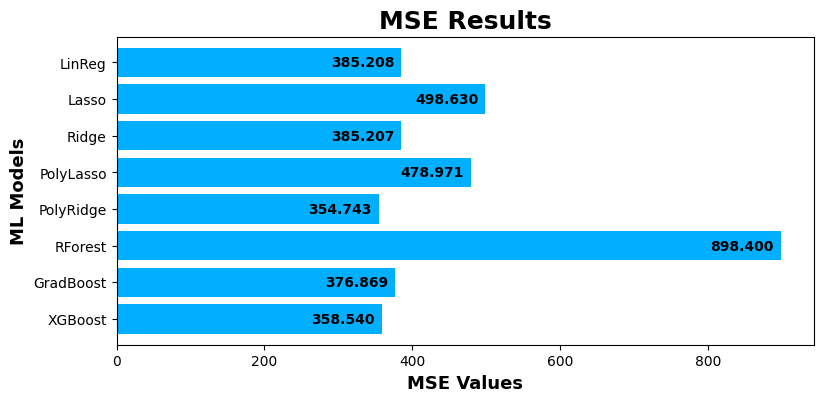

In [45]:
methods = ['LinReg', 'Lasso', 'Ridge', 'PolyLasso', 'PolyRidge', 'RForest', 'GradBoost', 'XGBoost']
plt.figure(figsize=(9,4))
plt.barh(range(8), res_mse, color='#00afff')
plt.title("MSE Results", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('MSE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_mse[i]-95, i+0.12, "{:.3f}".format(res_mse[i]), fontweight='bold')
plt.show()

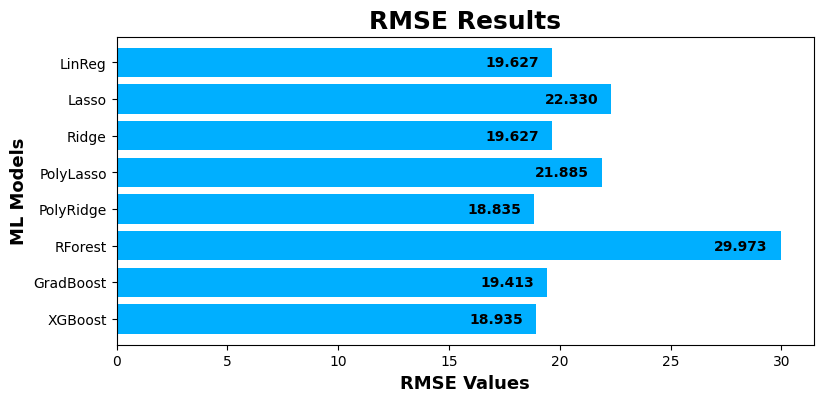

In [46]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_rmse, color='#00afff')
plt.title("RMSE Results", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('RMSE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_rmse[i]-3, i+0.12, "{:.3f}".format(res_rmse[i]), fontweight='bold')
plt.show()

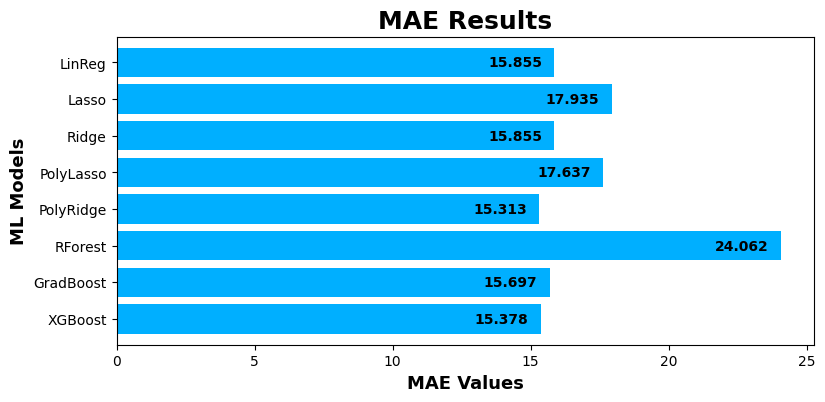

In [47]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_mae, color='#00afff')
plt.title("MAE Results", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('MAE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_mae[i]-2.4, i+0.12, "{:.3f}".format(res_mae[i]), fontweight='bold')
plt.show()

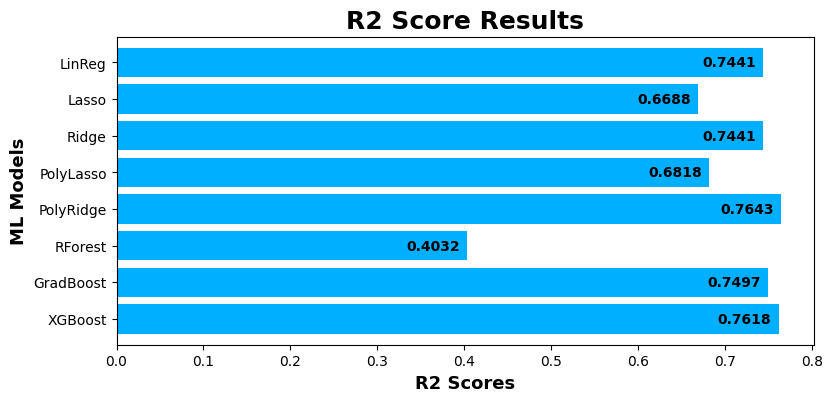

In [48]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_r2, color='#00afff')
plt.title("R2 Score Results", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('R2 Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_r2[i]-0.07, i+0.12, "{:.4f}".format(res_r2[i]), fontweight='bold')
plt.show()

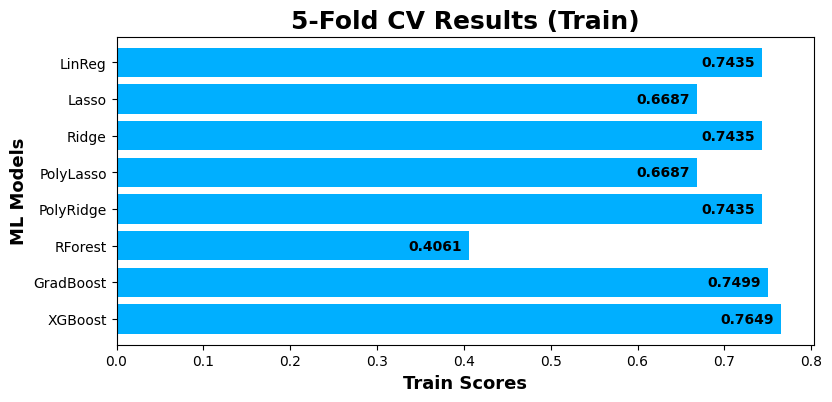

In [49]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_cv_train, color='#00afff')
plt.title("5-Fold CV Results (Train)", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('Train Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_cv_train[i]-0.07, i+0.12, "{:.4f}".format(res_cv_train[i]), fontweight='bold')
plt.show()

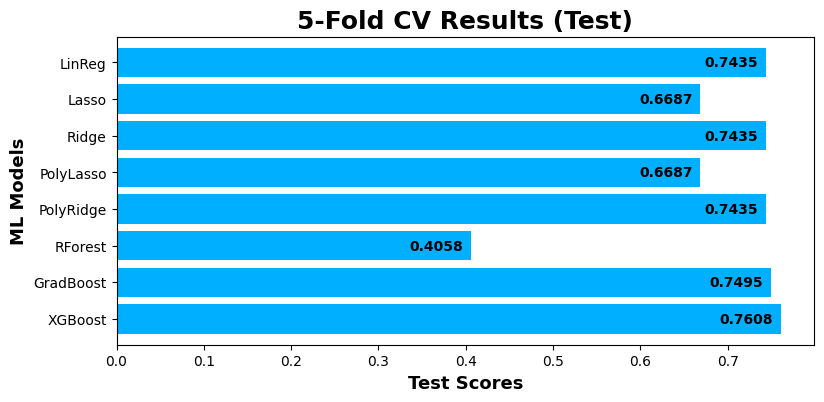

In [50]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_cv_test, color='#00afff')
plt.title("5-Fold CV Results (Test)", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('Test Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_cv_test[i]-0.07, i+0.12, "{:.4f}".format(res_cv_test[i]), fontweight='bold')
plt.show()